# **LeukemiaAI**

**A Revolutionary Tool in the Fight Against ALL** <br>
a fully integrated AI Classification pipeline to detect Acute lymphocytic leukemia (ALL)


**github repo**: https://github.com/MohammedSaLah-Eldeen/LeukemiaAI <br>
**fine-tuned Model**: https://huggingface.co/SuperMaker/vit-base-patch16-224-in21k-leukemia

### Leukemia

Leukemia is a cancer of the blood cells. It starts in the bone marrow, where new blood cells are made. When you have leukemia, your bone marrow makes too many abnormal blood cells. These cells crowd out the healthy blood cells, which can make you feel tired, weak, and sick.

#### Types of Leukemia

There are two main types of leukemia: acute and chronic.

* **Acute leukemia** is a cancer that can progress quickly. It is the most common type of leukemia in children.
* **Chronic leukemia** is a cancer that progresses slowly. It is more common in adults.

Leukemia can also be classified by the type of blood cell that is affected. The four main types of leukemia are:

* **Acute lymphocytic leukemia (ALL)** is a cancer of lymphocytes, which are a type of white blood cell.
* **Acute myeloid leukemia (AML)** is a cancer of myeloid cells, which are a type of white blood cell, red blood cell, or platelet.
* **Chronic lymphocytic leukemia (CLL)** is a cancer of lymphocytes.
* **Chronic myeloid leukemia (CML)** is a cancer of myeloid cells.

Here are some resources for more information about leukemia:

* The American Cancer Society: [https://www.cancer.org/cancer/types/leukemia.html](https://www.cancer.org/cancer/types/leukemia.html)
* The Leukemia & Lymphoma Society: [https://www.lls.org/](https://www.lls.org/)

## **Dataset**
Visit: https://www.kaggle.com/datasets/andrewmvd/leukemia-classification/data <br>
to view the Data Card on Kaggle


In [1]:
%pip install reusables

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 4.6 MB/s eta 0:00:00


In [2]:
# system packages
import os
import sys
import pathlib
from dotenv import load_dotenv

# data handling tools.
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.metrics import classification_report, confusion_matrix

# Tensorflow.
import tensorflow as tf
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers.schedules import CosineDecay
from tensorflow.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.data import Dataset as TFDataset


# Huggingface Transformers
import datasets
from transformers import ViTFeatureExtractor, TFViTForImageClassification
from transformers import DefaultDataCollator
from transformers.keras_callbacks import PushToHubCallback

# utility imports
import reusables
from typing import List
from huggingface_hub import notebook_login

# ignoring warnings.
from warnings import filterwarnings
filterwarnings('ignore')

load_dotenv()


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


False

Hugging Face Hub

In [3]:
# login
notebook_login()

In [5]:
DATA_FOLDER = '/kaggle/input/leukemia-classification'

Dataset splits paths.

In [6]:
TRAINING_DATA_FOLDER = os.path.join(DATA_FOLDER, 'C-NMC_Leukemia', 'training_data')
VALIDATION_DATA_FOLDER = os.path.join(DATA_FOLDER, 'C-NMC_Leukemia', 'validation_data')
TESTING_DATA_FOLDER = os.path.join(DATA_FOLDER, 'C-NMC_Leukemia', 'testing_data')

In [7]:
# define constants.
MODEL_CHECK_POINT = 'google/vit-base-patch16-224-in21k'
BATCH_SIZE = 64
EPOCHS = 14
INITIAL_LEARNING_RATE = 0.001
LABEL2ID = {'hem': 0, 'all': 1}
ID2LABEL = {0: 'hem', 1: 'all'}
FP16 = True
OUTPUT_DIR = MODEL_CHECK_POINT.split('/')[1]
HUB_MODEL_ID = f'{OUTPUT_DIR}-leukemia'
HUB_TOKEN = os.getenv('HUGGING_FACE_HUB_API_TOKEN')

if FP16:
    tf.keras.mixed_precision.set_global_policy("mixed_float16")

### **Loading Data**.

In [8]:
def extract_img_dataset(root_path):
  """creates `Dataset` from image folder structure"""

  classes = os.listdir(root_path)
  classes.reverse() # to reverse the labeling order, default: first -> 0, reversed: last -> 0

  features = datasets.Features(
    {
      "img": datasets.Image(),
      "label": datasets.features.ClassLabel(names=classes),
    }
  )

  img_files = []
  labels = []

  datapaths = list(os.walk(root_path))
  for idx in range(len(datapaths[0][1])):
    label = datapaths[0][1][idx]
    imgs = [os.path.abspath(os.path.join(root_path, label, img)) for img in datapaths[idx + 1][2]]
    img_files.extend(imgs)
    labels.extend([label] * len(imgs))

  ds = datasets.Dataset.from_dict(
    {
      "img": img_files,
      "label": labels
    },
    features=features
  )

  return ds

Training Data.

In [9]:
# loading datasets
fold_0 = extract_img_dataset(os.path.join(TRAINING_DATA_FOLDER, 'fold_0'))
fold_1 = extract_img_dataset(os.path.join(TRAINING_DATA_FOLDER, 'fold_1'))
fold_2 = extract_img_dataset(os.path.join(TRAINING_DATA_FOLDER, 'fold_2'))

train_dataset = datasets.concatenate_datasets([fold_0, fold_1, fold_2])
train_dataset

Dataset({
    features: ['img', 'label'],
    num_rows: 10661
})

 class: 0


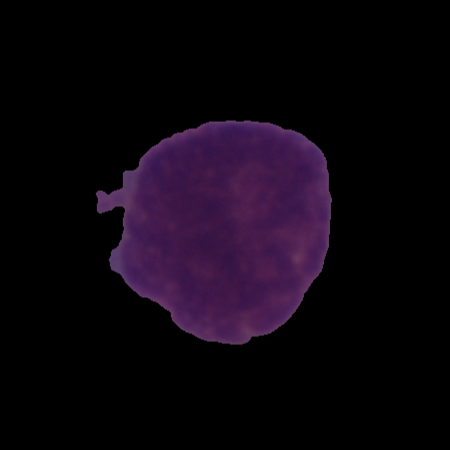

In [10]:
# load random sample.
randidx = np.random.randint(0, len(train_dataset) - 1)
print(f" class: {train_dataset[randidx]['label']}") 
train_dataset[randidx]['img']

Validation Data.

In [11]:
validation_df = pd.read_csv(os.path.join(VALIDATION_DATA_FOLDER, 'C-NMC_test_prelim_phase_data_labels.csv'))
validation_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1867 entries, 0 to 1866
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Patient_ID  1867 non-null   object
 1   new_names   1867 non-null   object
 2   labels      1867 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 43.9+ KB


In [12]:
# adding full paths to images
validation_df['new_names'] = validation_df['new_names'].map(
    lambda img: os.path.abspath(os.path.join(VALIDATION_DATA_FOLDER, 'C-NMC_test_prelim_phase_data', img))
)

# mapping ints to class names so they can be remapped easily
validation_df['labels'] = validation_df['labels'].map(
    lambda label: 'all' if label == 1 else 'hem'
)

In [13]:
# creating dataset
classes = ['hem', 'all']
labels = validation_df['labels'].to_list()
img_files = validation_df['new_names'].to_list()

features = datasets.Features(
    {
        'img': datasets.Image(),
        'label': datasets.features.ClassLabel(names=classes)
    }
)

validation_dataset = datasets.Dataset.from_dict(
    {
        'img': img_files,
        'label': labels
    },
    features=features
)

 class: 0


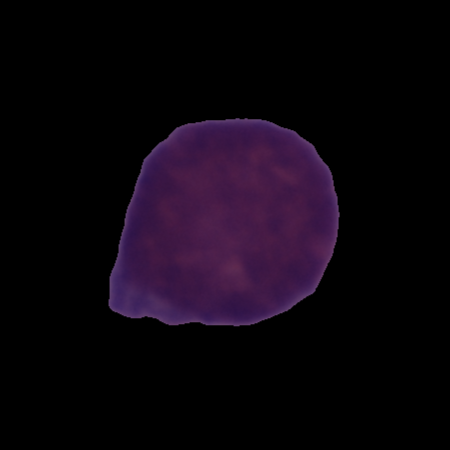

In [14]:
# load random sample.
randidx = np.random.randint(0, len(validation_dataset) - 1)
print(f" class: {validation_dataset[randidx]['label']}") 
validation_dataset[randidx]['img']

In [15]:
# full dataset
luekemia_dataset = datasets.DatasetDict(
    {
        'train': train_dataset,
        'validation': validation_dataset
    }
)

luekemia_dataset

DatasetDict({
    train: Dataset({
        features: ['img', 'label'],
        num_rows: 10661
    })
    validation: Dataset({
        features: ['img', 'label'],
        num_rows: 1867
    })
})

preprocessing

In [16]:
# getting ViT preprocessor
vit_preprocessor = ViTFeatureExtractor.from_pretrained(MODEL_CHECK_POINT)

In [17]:
def preprocess(samples):
    """
    to be used with `.map` on a hugging face dataset to preprocess the
    input images
    """
    samples.update(
        vit_preprocessor(samples['img'])
    )
    
    return samples

In [18]:
# to deal with packages incompatibilities
np.object = object
np.bool = bool

In [19]:
luekemia_dataset_preprocessed = luekemia_dataset.map(preprocess, batched=True)

  0%|          | 0/11 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [20]:
luekemia_dataset_preprocessed

DatasetDict({
    train: Dataset({
        features: ['img', 'label', 'pixel_values'],
        num_rows: 10661
    })
    validation: Dataset({
        features: ['img', 'label', 'pixel_values'],
        num_rows: 1867
    })
})

converting dataset to tensorflow dataset.

In [21]:
data_collator = DefaultDataCollator(return_tensors='tf')

tf_training_dataset = luekemia_dataset_preprocessed['train'].to_tf_dataset(
    columns=['pixel_values'],
    label_cols=['label'],
    shuffle=True,
    batch_size=BATCH_SIZE,
    collate_fn=data_collator
)

tf_validation_dataset = luekemia_dataset_preprocessed['validation'].to_tf_dataset(
    columns=['pixel_values'],
    label_cols=['label'],
    shuffle=True,
    batch_size=BATCH_SIZE,
    collate_fn=data_collator
)

loading the model.

In [22]:
vit = TFViTForImageClassification.from_pretrained(
    MODEL_CHECK_POINT,
    num_labels=2,
    id2label=ID2LABEL,
    label2id=LABEL2ID
)

Some layers from the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing TFViTForImageClassification: ['vit/pooler/dense/bias:0', 'vit/pooler/dense/kernel:0']
- This IS expected if you are initializing TFViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Configuring Callbacks.

In [23]:
early_sopping = EarlyStopping(
     monitor='val_accuarcy',
     patience=3
)

model_chkpt = ModelCheckpoint(
    filepath='models/checkpoints',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

board = TensorBoard(
    log_dir=os.path.join(OUTPUT_DIR, 'logs'),
    update_freq='batch'
)

to_hub = PushToHubCallback(
    output_dir=OUTPUT_DIR,
    hub_model_id=HUB_MODEL_ID,
)

callbacks = [early_sopping, model_chkpt, board, to_hub]

ValueError: Token is required (write-access action) but no token found. You need to provide a token or be logged in to Hugging Face with `huggingface-cli login` or `huggingface_hub.login`. See https://huggingface.co/settings/tokens.

Learning Rate Decay.

In [ ]:
update_steps = EPOCHS * BATCH_SIZE
lr_scheduler = CosineDecay(
    initial_learning_rate=0.001,
    decay_steps=update_steps,
)

Optimizer & Loss.

In [ ]:
optimizer = SGD(
    learning_rate=lr_scheduler,
    momentum=0.9,
    global_clipnorm=1
)

loss = SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
vit.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=['accuracy'],
)

#### Fine-tuning

In [ ]:
vit.fit(
    tf_training_dataset,
    validation_data=tf_validation_dataset,
    callbacks=callbacks,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)

In [ ]:
vit.push_to_hub('vit-base-patch16-224-in21k-leukemia', commit_message="end of fine-tuning")

In [ ]:
vit.config.label2id = LABEL2ID
vit.config.id2label = ID2LABEL
vit.config.push_to_hub('vit-base-patch16-224-in21k-leukemia')

In [ ]:
from huggingface_hub import HfApi

api = HfApi()

user = api.whoami()


vit_preprocessor.save_pretrained(OUTPUT_DIR)

api.upload_file(
    repo_id=f"{user['name']}/{HUB_MODEL_ID}",
    path_or_fileobj=os.path.join(OUTPUT_DIR, "preprocessor_config.json"),
    path_in_repo="preprocessor_config.json",
)
